In [799]:
import datetime as dt
import math

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.float_format = '{:.3f}'.format

# Overview
***
1. Data Extraction
2. Size Factor
3. Growth Factor
4. Value Factor
5. Risk Model
***

In this notebook I look at factor risk in the cyrpto currency market. I use volume_sum as a proxy for the size factor, the growth of txn_count as a proxy for growth and fee_mean_a as ap proxy for value.

The factor resturns are calculates as the return difference between the asset with the largest factor exposure and the asset with the smallest factor. The assets are revaluated once per month.

# 1) Data Extraction

In [800]:
blockchain_data = pd.read_csv('blockchain_data_20180601-20190601.csv')
assets = blockchain_data['asset_id'].unique() #A list of the assets included in the blockchain dataset

blockchain_data['dates'] = pd.to_datetime(blockchain_data['epoch_ts'])
dates = pd.DataFrame(blockchain_data['dates'].unique()) #The list of ates

blockchain_data = blockchain_data.set_index('dates',append=True) 

#Load the market data and calculate the log returns for the assets in the blockchain data.
#The returns are used to estimate the factor returns
market_data = pd.read_csv('market_data_20180601-20190601.csv')
market_data['dates'] = pd.to_datetime(market_data['epoch_ts'])
log_rets = market_data[market_data['base_asset_id'].isin(assets)].pivot_table(values=['price_close'],index='dates',columns='base_asset_id')
log_rets = np.log(log_rets).diff()
log_rets.columns = assets

#get_daily_factor_rets is used to calculate the factor returns for all factors. 
    #monthly_factors is the forward monthly rolled up factor levels
    #The function matches the daily log_rets to the largets and smallest factor exposures. 
def get_daily_factor_rets(monthly_factors):

    max_min = pd.DataFrame(monthly_factors.idxmax(axis=1).shift(1)).dropna() #The asset_id of the smallest factor
    max_min['min'] = monthly_factors.idxmin(axis=1).shift(1) #The asset_id of the largest factor

    min_d = max_min.index.min();max_d = max_min.index.max() #The first and last month
    #log_rets dats that are included in the range of monthly_factors
    new_dates = log_rets.index[(log_rets.index>=dt.datetime(min_d.year,min_d.month,1))&(log_rets.index<=max_min.index.max())]
    
    #rets will collect the factor returns
    rets = pd.DataFrame(index=new_dates, columns=['max_ret','min_ret','relative_ret'])

    #loop through all of the dates in rets
    for i in rets.index:
        d = dt.datetime(i.year,i.month,28)+dt.timedelta(days=10)
        cur_month = dt.datetime(d.year,d.month,1)-dt.timedelta(days=1) #The current date for the monthly factor data
        max_g = max_min.loc[cur_month,0] #asset_id of asset with smallest factor value at current month
        min_g = max_min.loc[cur_month,'min'] #asset_id of asset with largest factor value at current month
        if isinstance(max_g, str): #Ignore nan
            rets.loc[i,'max_ret'] = log_rets.loc[i,max_g] #Set max ret
            rets.loc[i,'min_ret'] = log_rets.loc[i,min_g] #Set min ret

    rets['relative_ret'] = rets['max_ret']-rets['min_ret'] #Set relative return
    return(rets)

#plot_factor_index is used to plot the factor returns for all of the factors
def plot_factor_index(factor_log_rets, factor):
    plt.figure(figsize=(20,10))
    factor_log_rets = np.exp(factor_log_rets['relative_ret'].astype(float)).cumprod()
    plt.plot(factor_log_rets,label=factor+' factor', linewidth=5)
    for a in assets:
        plt.plot(np.exp(log_rets[a]).loc[new_dates].cumprod(),label=a)
        plt.title('Return of ' + factor + ' Factor Versus Assets')
    plt.legend(loc='upper center',ncol=2)
    plt.show()

# 2) Size Factor
***

The "size" factor is an attempt to imitate the market value factor commonly used in equity factor analysis. Size is estimated as the total trnsacted blockchain volume. The volume is measured as the average volume over the prevoius month.

       Bitcoin_BTC_BTC  Dash_DASH_DASH  Ethereum_ETH_ETH  Litecoin_LTC_LTC  \
count          366.000         366.000           366.000           362.000   
mean       1169619.804      275599.261       2307759.505        405340.144   
std         488854.546      439071.417       1374153.597        465077.345   
min         500647.360       48509.881        790117.631         53842.363   
25%         859068.595      119001.339       1623376.548        119726.149   
50%        1061770.457      167783.797       2076490.320        205546.132   
75%        1368075.797      272273.458       2653676.417        410337.575   
max        3759153.895     5509632.814      17368049.100       1966596.033   

       Zcash_ZEC_ZEC  Horizen_ZEN_ZEN  
count        365.000          366.000  
mean     3857967.616      1159884.426  
std      2520645.035       880647.426  
min      1276155.441       144230.216  
25%      2676627.594       552325.494  
50%      3286110.802       898106.636  
75%      4290813.

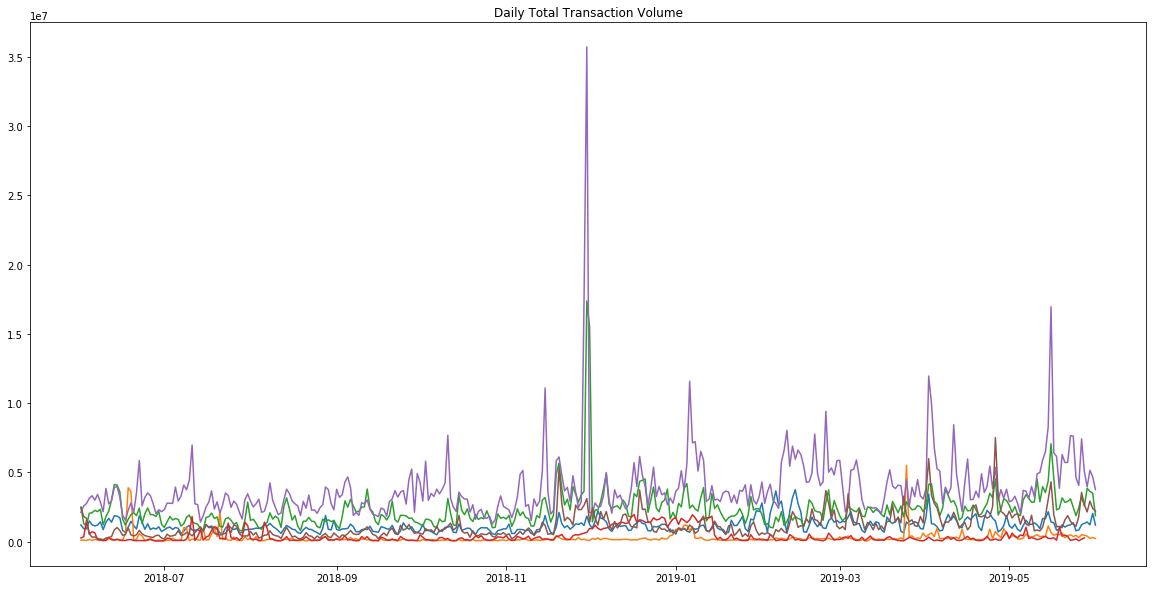

In [802]:
#Create size DataFrame
size = pd.pivot_table(blockchain_data,values=['volume_sum'],index='dates',columns='asset_id')
size.columns = assets
print(size.describe())
print("\nTwo of the assets are missing data")

plt.figure(figsize=(20,10))
plt.plot(size)
plt.title('Daily Total Transaction Volume')
plt.show()

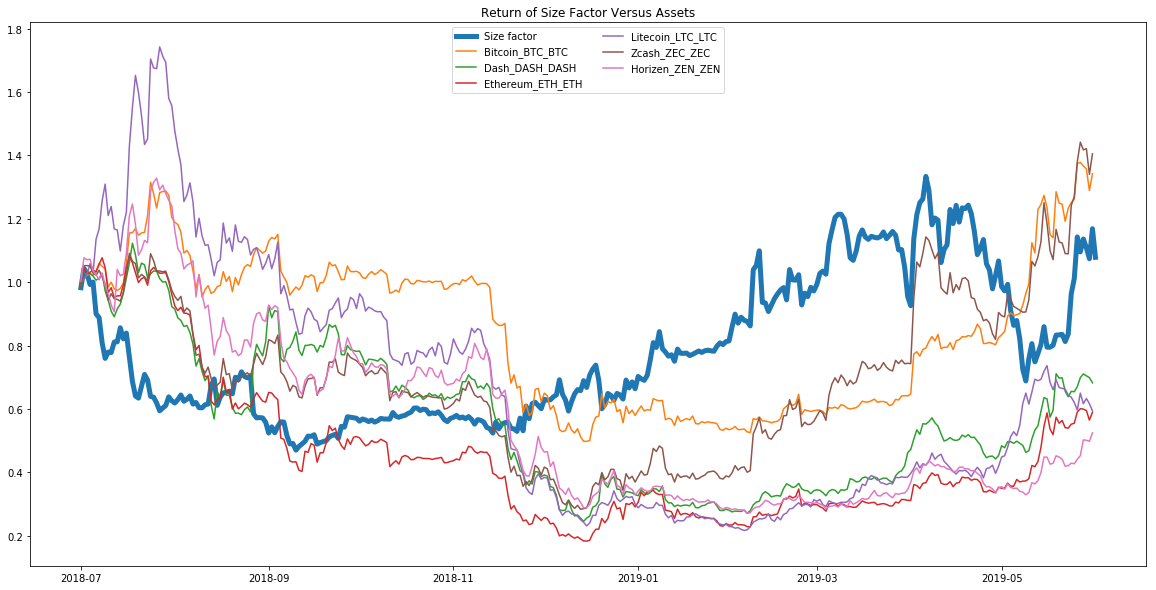

In [803]:
#Volume is averaged by month
monthly_volume = size.resample('M').mean()

#Get daily factor returns based on prevoius month-end volume 
rets_size = get_daily_factor_rets(monthly_volume)

plot = plot_factor_index(rets_size,'Size')

# 3) Growth Factor
***

The "growth" factor is an attempt to imitate a growth metric that may be used in equity factor analysis. Growth is estimated as the growth in blockchain transaction count. It is measured as the average growth rate during the previous month. 

       Bitcoin_BTC_BTC  Dash_DASH_DASH  Ethereum_ETH_ETH  Litecoin_LTC_LTC  \
count          366.000         366.000           366.000           362.000   
mean        274337.352       24126.978        614472.861         16062.453   
std          63968.756      160563.142        108367.476          8313.726   
min         144908.000        3961.000        385630.000          5030.000   
25%         226186.250        9164.000        543992.000         11138.250   
50%         262764.000       11544.000        587728.000         13544.500   
75%         322019.000       14689.500        680107.500         17763.250   
max         452646.000     3022387.000        960926.000         62638.000   

       Zcash_ZEC_ZEC  Horizen_ZEN_ZEN  
count        365.000          366.000  
mean       25435.142         4304.978  
std         3976.618         1995.771  
min        18331.000         2339.000  
25%        23505.000         3240.500  
50%        25004.000         3686.500  
75%        26728.

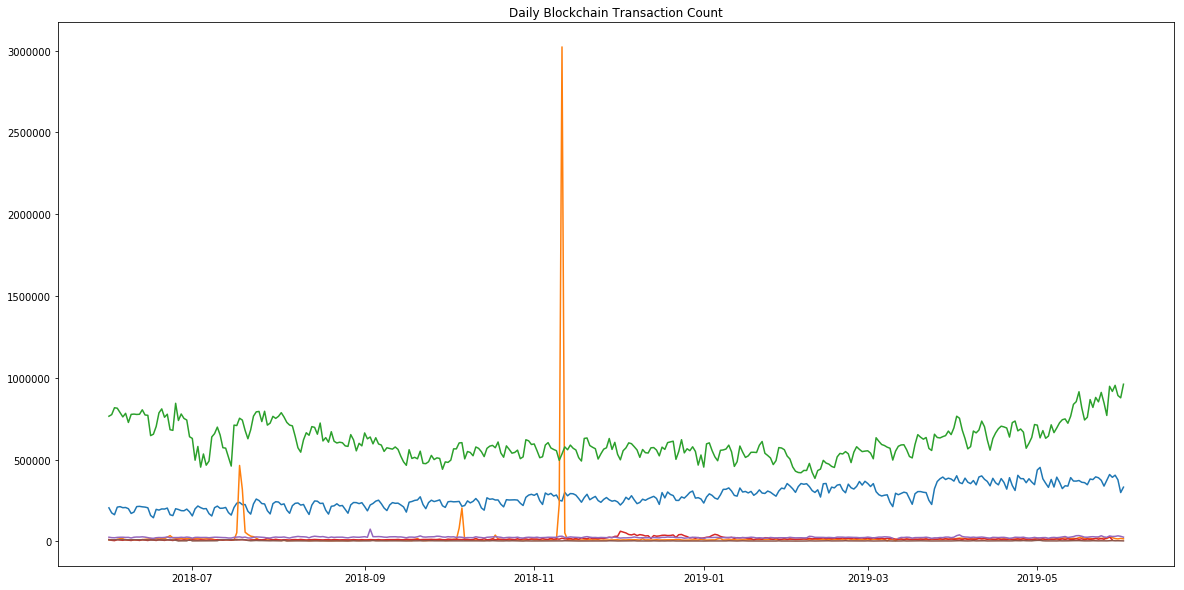

In [804]:
growth = pd.pivot_table(blockchain_data,values=['txn_count'],index='dates',columns='asset_id')
growth.columns = assets
print(growth.describe())

plt.figure(figsize=(20,10))
plt.plot(growth)
plt.title('Daily Blockchain Transaction Count')
plt.show()

The blockchain transaction data has some outliers that are large enough to impact the monhtly rate. In addition, there appears to be seasonality in the data. 

#### Missing Values & Outliers

            Bitcoin_BTC_BTC  Dash_DASH_DASH  Ethereum_ETH_ETH  \
dates                                                           
2019-03-11       294741.000        5212.000        551986.000   
2019-05-29       405155.000       17562.000        954282.000   
2019-05-30       376874.000       15755.000        892068.000   
2019-05-31       298997.000       18709.000        877852.000   
2019-06-01       331938.000       16133.000        960926.000   

            Litecoin_LTC_LTC  Zcash_ZEC_ZEC  Horizen_ZEN_ZEN  
dates                                                         
2019-03-11         14429.000            nan         2963.000  
2019-05-29               nan      31057.000         4156.000  
2019-05-30               nan      34429.000         4512.000  
2019-05-31               nan      31569.000         3893.000  
2019-06-01               nan      26363.000         3678.000  

The missing data is clustered over a few periods


Text(0.5, 1.0, 'Blockchain Seasonally Adjusted Transaction Trend')

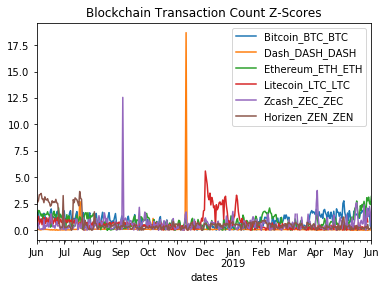

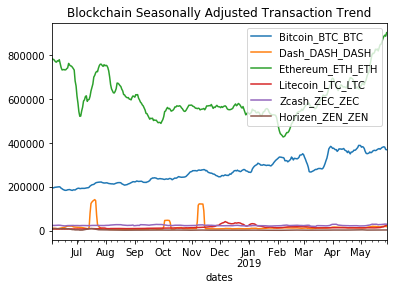

In [805]:
#Missing Values
print(growth[growth.isnull().any(axis=1)])
print('\nThe missing data is clustered over a few periods')

zscores = growth.sub(growth.mean()).div(growth.std()).abs()
zscores.plot()
plt.title('Blockchain Transaction Count Z-Scores')

#Observations with a z-score greater than 5 are replaced with an nan
growth = growth.mask(zscores.gt(5))
#Backfill all nan values
growth = growth.fillna(method='bfill',axis=1)

#Use the trend component of a simple seasonal decomposition
growth_trend = seasonal_decompose(growth).trend.dropna()
growth_trend.plot()
plt.title('Blockchain Seasonally Adjusted Transaction Trend')

#### Relative Return

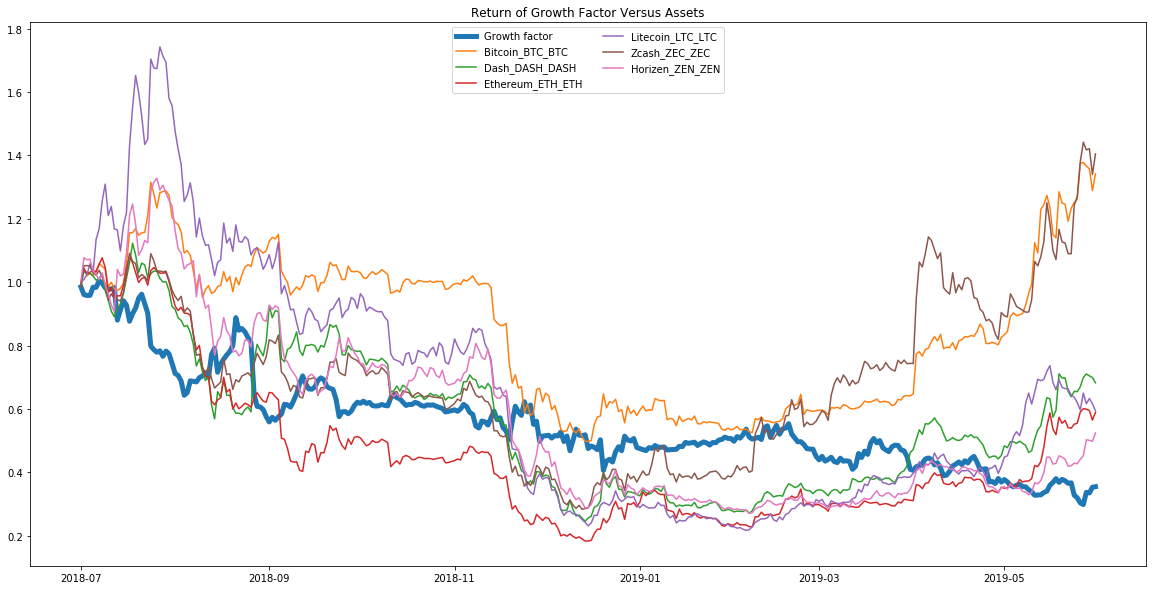

In [806]:
#THe factor is estimated as the average monthly log change of the seasonally adjusted trend
monthly_growth = (np.log(growth_trend)).diff().resample('M').sum()

rets_growth = get_daily_factor_rets(monthly_growth)

plot_factor_index(rets_growth,'Growth')

The growth factor underperformed during the year as assets with the largets transaction growth underperformed assets with the smallest transaction growth.  

# 4) Value Factor
***
The "value" factor is an attempt to imitate a value (i.e. book value) metric that may be used in equity factor analysis. Value is estimated as the average blockchain fee volume. It is measured as the average during the previous month. 

       Bitcoin_BTC_BTC  Dash_DASH_DASH  Ethereum_ETH_ETH  Litecoin_LTC_LTC  \
count          366.000         366.000           366.000           366.000   
mean        274337.352       17330.044        614472.861         16012.691   
std          63968.756       42655.454        108367.476          7766.927   
min         144908.000        3961.000        385630.000          5030.000   
25%         226186.250        9164.000        543992.000         11154.250   
50%         262764.000       11544.000        587728.000         13627.500   
75%         322019.000       14689.500        680107.500         17870.750   
max         452646.000      534709.000        960926.000         52136.000   

       Zcash_ZEC_ZEC  Horizen_ZEN_ZEN  
count        366.000          366.000  
mean       25177.762         4304.978  
std         3399.233         1995.771  
min         2963.000         2339.000  
25%        23427.250         3240.500  
50%        24939.500         3686.500  
75%        26725.

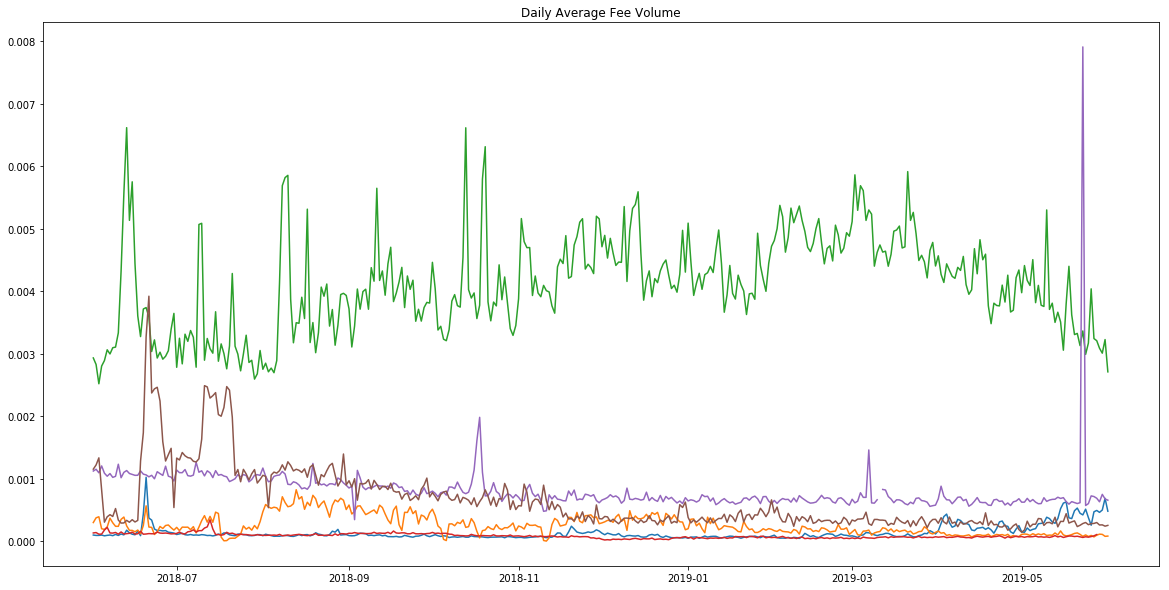

In [807]:
value = pd.pivot_table(blockchain_data,values=['fee_mean_a'],index='dates',columns='asset_id')
value.columns = assets
print(growth.describe())

plt.figure(figsize=(20,10))
plt.plot(value)
plt.title('Daily Average Fee Volume')
plt.show()

The value factor also need to be seasonally adjusted.

            Bitcoin_BTC_BTC  Dash_DASH_DASH  Ethereum_ETH_ETH  \
dates                                                           
2019-03-11            0.000           0.000             0.005   
2019-05-29            0.000           0.000             0.003   
2019-05-30            0.000           0.000             0.003   
2019-05-31            0.001           0.000             0.003   
2019-06-01            0.000           0.000             0.003   

            Litecoin_LTC_LTC  Zcash_ZEC_ZEC  Horizen_ZEN_ZEN  
dates                                                         
2019-03-11             0.000            nan            0.000  
2019-05-29               nan          0.001            0.000  
2019-05-30               nan          0.001            0.000  
2019-05-31               nan          0.001            0.000  
2019-06-01               nan          0.001            0.000  


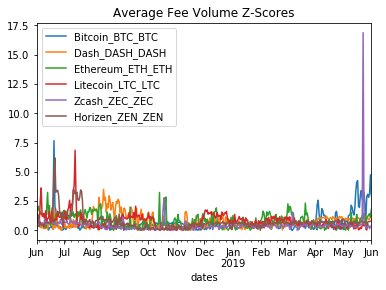

In [808]:
#Missing Values
print(value[value.isnull().any(axis=1)])

zscores = value.sub(value.mean()).div(value.std()).abs()
zscores.plot()
plt.title('Average Fee Volume Z-Scores')

#Replace values with a z-score over 5 with nan and backfill all nan
value = value.mask(zscores.gt(5)).fillna(method='bfill',axis=1).fillna(method='ffill',axis=1)

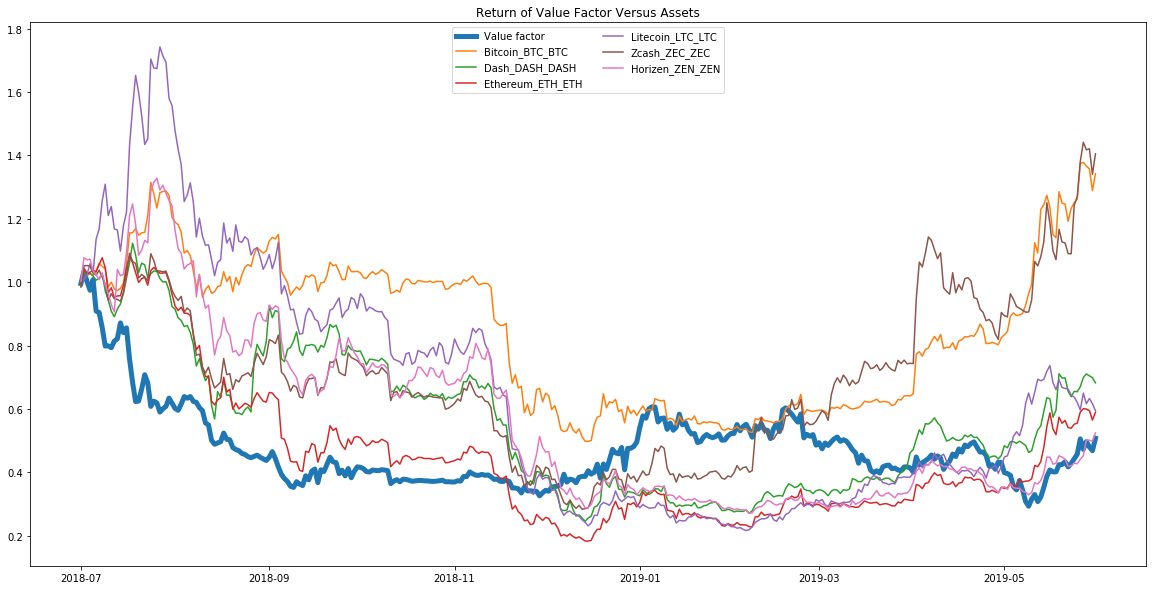

In [809]:
#Seasonally adjusted trend 
value_trend = seasonal_decompose(value).trend.dropna()
#Seasonally adjusted averaged over each month
monthly_value = value_trend.resample('M').mean()
#Factor returns
rets_value = get_daily_factor_rets(monthly_value)

plot_factor_index(rets_value,'Value')

# Risk Model
***
This section presents the factor decompositions as a potential tool to measue and adjust exposure to different risk factors. The factor exposures are measured via a rolling linear regresion. 

I would usually use a kalman filter for this, but I wanted to stick with Anaconda packages. 

In [810]:
#X is a data frame of the three factor returns
X = pd.concat([rets_size['relative_ret'],rets_growth['relative_ret'],rets_value['relative_ret']],axis=1).iloc[:-1,:]
X.columns = ['size','growth','value']
#y is the dataframe of the asset returns
y=log_rets.loc[X.index]

win_size = 120 #Factor exposures are measured over a rolling 120 day window

size_exp = pd.DataFrame(X.index[win_size:],columns=assets)
growth_exp = pd.DataFrame(X.index[win_size:],columns=assets)
value_exp = pd.DataFrame(X.index[win_size:],columns=assets)
rp = pd.DataFrame(X.index[win_size:],columns=X.columns)

#Loop throuht the assets
for a in assets:
    y_dat = y[a]
    #Rolling linear regression
    for d in X.index[win_size:]: #Loop through dates starting at win_size
        cur_X = X.loc[(d-dt.timedelta(days=win_size)):d]
        cur_y = y_dat.loc[(d-dt.timedelta(days=win_size)):d]
    
        model = LinearRegression().fit(cur_X,cur_y)
        coefs = model.coef_
        size_exp.loc[d,a] = coefs[0]
        growth_exp.loc[d,a] = coefs[1]
        value_exp.loc[d,a] = coefs[2]
        rp.loc[d,a] = model.intercept_

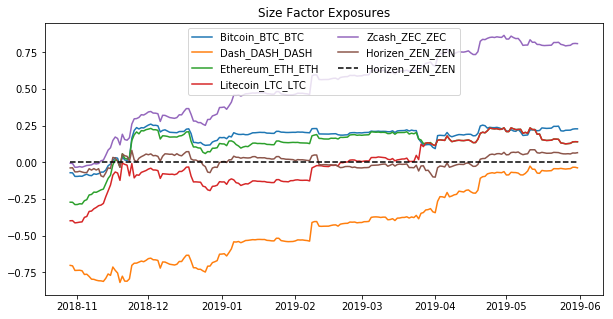

Zcash has a very large exposure to the size factor.


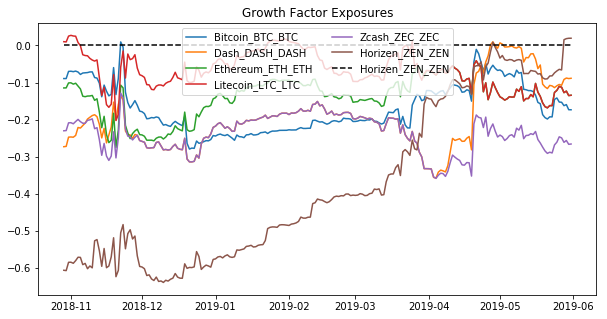

Most assets have a negative exposure to the growth factor.


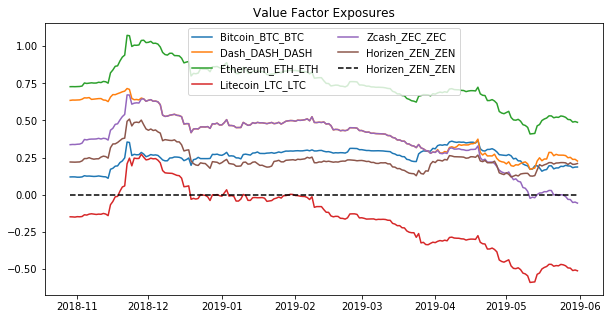

Dash has a large inverse exposure to the value factor.


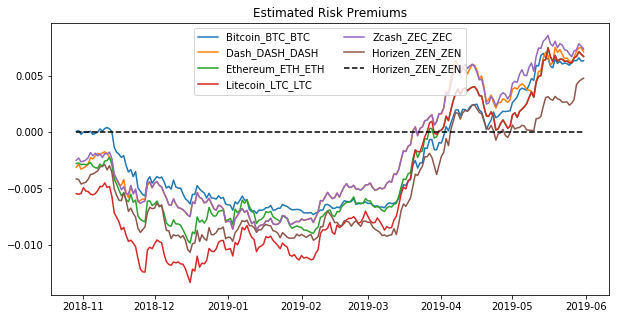

Risk premiums have been rising since the first quarter of 2019.


In [811]:
#Plot factor exposures
def plot_factors(data,title):
    plt.figure(figsize=(10,5))
    for a in assets:
        plt.plot(data[a],label=a)
    plt.plot(data[a]*0, '--', color='black')
    plt.legend(loc='upper center',ncol=2)
    plt.title(title)
    plt.show()

plot_factors(size_exp, 'Size Factor Exposures')
print('Zcash has a very large exposure to the size factor.')
plot_factors(growth_exp, 'Growth Factor Exposures')
print('Most assets have a negative exposure to the growth factor.')
plot_factors(value_exp,'Value Factor Exposures')
print('Dash has a large inverse exposure to the value factor.')
plot_factors(rp,'Estimated Risk Premiums')
print('Risk premiums have been rising since the first quarter of 2019.')

# Conclusion
***

By estimating factor exposures, a crypto asset investor could effective monitor and adjust their exposure to various risks. Adjustments could include making factor specific bets or neutralizing factor risk exposures. 